# Model Benchmarking and Selection
This notebook benchmarks multiple ML and DL models on a randomly sampled subset of the dataset. It evaluates models using metrics such as accuracy, recall, precision, F1 score, MCC, MSE, RMSE, and R2, and visualizes confusion matrices. The best model is selected based on these metrics.

In [25]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import joblib
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, mean_squared_error, r2_score, confusion_matrix)

## Load Dataset
Load the main dataset for benchmarking.

In [26]:
# Load the dataset
dataset_path = 'DATASET_FINAL_NO_STOPWORDS.csv'
df = pd.read_csv(dataset_path)
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (21584, 2)


,Sentiment,Label
0,magmaan,positive
1,mahiwason,positive
2,simpleng baha nanaman lriga,negative
3,uda karapatan reklamo kadaklan bayad 3 taon ha...,negative
4,maray diri apektado,negative


## Select 20% Random Sample and Save
Randomly select 20% of the dataset and save to a new CSV file for benchmarking.

In [27]:
# Select a balanced 20% random sample and save
sentiments = ['neutral', 'positive', 'negative']
sample_frac = 0.2
n_total = int(len(df) * sample_frac)
n_per_class = n_total // 3
sample_df = pd.concat([df[df['Label'] == s].sample(n=n_per_class, random_state=42) for s in sentiments])
sample_path = 'DATASET_BENCHMARK_SAMPLE.csv'
sample_df.to_csv(sample_path, index=False)
print(f"Sampled balanced dataset shape: {sample_df.shape}")
print(sample_df['Label'].value_counts())
sample_df.head()

Sampled balanced dataset shape: (4314, 2)
Label
neutral     1438
positive    1438
negative    1438
Name: count, dtype: int64


,Sentiment,Label
17193,siguruwun makapag tau oryentasyon miyembro gag...,neutral
19167,school paryu iskwila grade,neutral
20409,tandaan pagkopya parirala importante tandaan s...,neutral
6591,kanakong rurugan,neutral
19008,importante maintindiyan maray binasa itinau,neutral


## Load Models from Folder
Load all ML and DL models and their associated vectorizers/tokenizers for benchmarking.

In [28]:
# Helper functions to load models and vectorizers/tokenizers
def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

def load_joblib(path):
    return joblib.load(path)

def load_keras(path):
    from tensorflow import keras
    return keras.models.load_model(path)

ml_folder = 'ML'
dl_folder = 'DL'

# Only use SVM and CNN for comparison
ml_models = {
    'SVM': {
        'model': load_joblib(os.path.join(ml_folder, 'SVM_model.obj')),
        'vectorizer': load_joblib(os.path.join(ml_folder, 'SVM_tfidf_vectorizer.obj'))
    }
}
dl_models = {
    'CNN': {
        'model': load_keras(os.path.join(dl_folder, 'cnn_model.keras')),
        'tokenizer': load_pickle(os.path.join(dl_folder, 'cnn_tokenizer.obj'))
    }
}

## Benchmark Models on Sampled Dataset
Use each loaded model to make predictions on the sampled dataset.

In [29]:
# Prepare X and y for benchmarking
# Ensure this cell is run before benchmarking models
# If not present, add this before model benchmarking cells

target_col = 'Label'  # Change if your target column is named differently
X_sample = sample_df.drop(columns=[target_col])
y_sample = sample_df[target_col]

results = {}

# Benchmark ML model (SVM only)
for name, items in ml_models.items():
    vectorizer = items['vectorizer']
    model = items['model']
    X_vec = vectorizer.transform(X_sample.squeeze().astype(str))
    y_pred = model.predict(X_vec)
    results[name] = {'y_true': y_sample, 'y_pred': y_pred}

In [30]:
# Benchmark ML models
for name, items in ml_models.items():
    vectorizer = items['vectorizer']
    model = items['model']
    X_vec = vectorizer.transform(X_sample.squeeze().astype(str))
    y_pred = model.predict(X_vec)
    results[name] = {'y_true': y_sample, 'y_pred': y_pred}

In [31]:
# Define DL input preparation function if not already defined

def prepare_dl_input(tokenizer, texts, maxlen=100):
    sequences = tokenizer.texts_to_sequences(texts)
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    return pad_sequences(sequences, maxlen=maxlen)

In [32]:
# Benchmark DL models
for name, items in dl_models.items():
    tokenizer = items['tokenizer']
    model = items['model']
    X_seq = prepare_dl_input(tokenizer, X_sample.squeeze().astype(str))
    y_pred = model.predict(X_seq)
    # If output is probabilities, take argmax
    if y_pred.ndim > 1 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)
    else:
        y_pred = (y_pred > 0.5).astype(int).flatten()
    results[name] = {'y_true': y_sample, 'y_pred': y_pred}

135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


## Calculate Metrics: Accuracy, Recall, Precision, F1 Score, MCC, MSE, RMSE, R2
Compute all specified metrics for each model.

In [33]:
# Benchmark DL model (CNN only)
for name, items in dl_models.items():
    tokenizer = items['tokenizer']
    model = items['model']
    X_seq = prepare_dl_input(tokenizer, X_sample.squeeze().astype(str))
    y_pred = model.predict(X_seq)
    # If output is probabilities, take argmax
    if y_pred.ndim > 1 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)
    else:
        y_pred = (y_pred > 0.5).astype(int).flatten()
    results[name] = {'y_true': y_sample, 'y_pred': y_pred}

135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


## Display Confusion Matrix Heatmap
Plot a confusion matrix heatmap for each model.

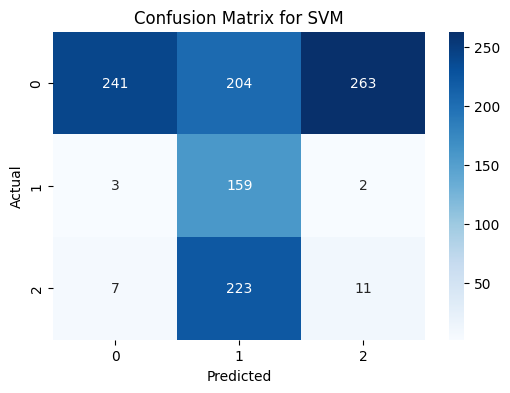

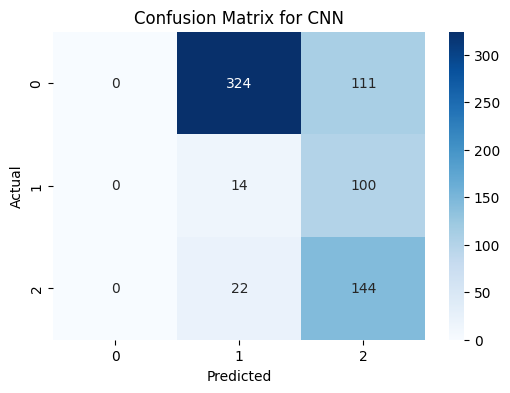

In [34]:
# Plot confusion matrix heatmap for each model
for name, res in results.items():
    y_true = res['y_true']
    y_pred = res['y_pred']
    # Ensure both are string labels for confusion matrix
    label_map = {'neutral': 0, 'positive': 1, 'negative': -1}
    if not isinstance(y_true.iloc[0], str):
        inv_label_map = {v: k for k, v in label_map.items()}
        y_true_cm = pd.Series(y_true).map(inv_label_map)
    else:
        y_true_cm = pd.Series(y_true)
    if not isinstance(y_pred[0], str):
        inv_label_map = {v: k for k, v in label_map.items()}
        y_pred_cm = pd.Series(y_pred).map(inv_label_map)
    else:
        y_pred_cm = pd.Series(y_pred)
    # Filter out any NaNs that may have resulted from mapping
    mask = (~y_true_cm.isna()) & (~y_pred_cm.isna())
    y_true_cm = y_true_cm[mask]
    y_pred_cm = y_pred_cm[mask]
    cm = confusion_matrix(y_true_cm, y_pred_cm)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

## Select and Display Best Model Based on Metrics
Compare all models based on the computed metrics and display the best performing model.

In [ ]:
# Calculate metrics for each model and select best
label_map = {'neutral': 0, 'positive': 1, 'negative': -1}
metrics = {}
for name, res in results.items():
    y_true = res['y_true']
    y_pred = res['y_pred']
    # Determine if labels are strings or numbers
    if isinstance(y_true.iloc[0], str):
        if not isinstance(y_pred[0], str):
            inv_label_map = {v: k for k, v in label_map.items()}
            y_pred_class = pd.Series(y_pred).map(inv_label_map)
        else:
            y_pred_class = pd.Series(y_pred)
        y_true_class = pd.Series(y_true)
        y_true_num = y_true_class.map(label_map)
        y_pred_num = y_pred_class.map(label_map) if isinstance(y_pred_class.iloc[0], str) else y_pred_class
    else:
        y_true_num = pd.Series(y_true)
        y_pred_num = pd.Series(y_pred)
        y_true_class = y_true_num
        y_pred_class = y_pred_num
    mask = (~y_true_class.isna()) & (~y_pred_class.isna())
    y_true_class = y_true_class[mask]
    y_pred_class = y_pred_class[mask]
    y_true_num = y_true_num[mask]
    y_pred_num = y_pred_num[mask]
    metrics[name] = {
        'Accuracy': accuracy_score(y_true_class, y_pred_class),
        'Recall': recall_score(y_true_class, y_pred_class, average='weighted', zero_division=0),
        'Precision': precision_score(y_true_class, y_pred_class, average='weighted', zero_division=0),
        'F1 Score': f1_score(y_true_class, y_pred_class, average='weighted', zero_division=0),
        'MCC': matthews_corrcoef(y_true_class, y_pred_class),
        'MSE': mean_squared_error(y_true_num, y_pred_num),
        'RMSE': np.sqrt(mean_squared_error(y_true_num, y_pred_num)),
        'R2': r2_score(y_true_num, y_pred_num)
    }
metrics_df = pd.DataFrame(metrics).T
best_model = metrics_df['Accuracy'].idxmax()
print(f"Best model based on Accuracy: {best_model}")
print(metrics_df.loc[best_model])

NameError: name 'metrics_df' is not defined